In [2]:
# Importe as bibliotecas que eu usei para carregar dados, treinar e avaliar
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

In [3]:
# Defini o caminho do dataset 
csv_path = Path(r"C:\Users\Willgnner\Documents\Atividades-Aprendizado-de-Máquina\Notebooks\Entrega-slides-5\Dados\SpamBase\spambase.csv")
csv_path

WindowsPath('C:/Users/Willgnner/Documents/Atividades-Aprendizado-de-Máquina/Notebooks/Entrega-slides-5/Dados/SpamBase/spambase.csv')

In [4]:
# Desenvolvi um carregador robusto:
# - Se o CSV vier SEM cabeçalho, eu criei nomes f0..f56 e usei a última coluna como target
# - Se vier COM cabeçalho, eu mantive e ainda assim tratei a última coluna como target

def carregar_spambase(path: Path) -> tuple[pd.DataFrame, pd.Series]:
    df = pd.read_csv(path)

    # Se existir alguma coluna não numérica, eu tratei como indício de header estranho
    # e tentei recarregar sem header.
    if any(df.dtypes == "object"):
        df = pd.read_csv(path, header=None)

    # Se o dataset vier no formato clássico (57 features + 1 target = 58 colunas), eu ajustei nomes
    if df.shape[1] == 58:
        df.columns = [f"f{i}" for i in range(57)] + ["target"]
    else:
        # Se por algum motivo não der 58, eu ainda assim peguei a última coluna como target
        df = df.copy()
        df.columns = [f"f{i}" for i in range(df.shape[1]-1)] + ["target"]

    # Separei X e y
    X = df.drop(columns=["target"])
    y = df["target"].astype(int)

    # Garanti que X ficou numérico
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    return X, y

X, y = carregar_spambase(csv_path)

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Distribuição do target (0=ham, 1=spam):")
print(y.value_counts(normalize=True).round(4))

Shape X: (4601, 57)
Shape y: (4601,)
Distribuição do target (0=ham, 1=spam):
target
0    0.606
1    0.394
Name: proportion, dtype: float64


In [5]:
# Criei um split bem justo:
# - Separei um conjunto de TESTE (fixo) para eu avaliar os modelos no final
# - No conjunto de TREINO, eu mantive só 10% como rotulado e 90% como não rotulado

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Aqui eu simulei "poucos rótulos": só 10% do treino fica rotulado
X_lab, X_unlab, y_lab, y_unlab_true = train_test_split(
    X_train_full, y_train_full,
    test_size=0.90,
    stratify=y_train_full,
    random_state=42
)

print("Treino total:", X_train_full.shape[0])
print("Rotulado (10% do treino):", X_lab.shape[0])
print("Não rotulado (90% do treino):", X_unlab.shape[0])
print("Teste:", X_test.shape[0])

Treino total: 3680
Rotulado (10% do treino): 368
Não rotulado (90% do treino): 3312
Teste: 921


In [6]:
# Desenvolvi uma função de avaliação para eu comparar os modelos usando:
# - precision, recall, f1 (para a classe positiva = spam)
# - matriz de confusão
# - classification report

def avaliar_modelo(modelo, X_eval, y_eval, nome="modelo"):
    y_pred = modelo.predict(X_eval)

    prec = precision_score(y_eval, y_pred, pos_label=1)
    rec  = recall_score(y_eval, y_pred, pos_label=1)
    f1   = f1_score(y_eval, y_pred, pos_label=1)
    cm   = confusion_matrix(y_eval, y_pred)

    print(f"\n===== Avaliei: {nome} =====")
    print(f"Precision (spam=1): {prec:.4f}")
    print(f"Recall    (spam=1): {rec:.4f}")
    print(f"F1-score  (spam=1): {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_eval, y_pred, digits=4))

    return {"nome": nome, "precision": prec, "recall": rec, "f1": f1, "cm": cm}

In [7]:
# Treinei um baseline supervisionado usando apenas os 10% rotulados
# Eu usei StandardScaler + LogisticRegression por ser um baseline bem comum e estável em dados numéricos

baseline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, random_state=42))
])

baseline.fit(X_lab, y_lab)

res_baseline = avaliar_modelo(baseline, X_test, y_test, nome="Baseline (só 10% rotulado)")


===== Avaliei: Baseline (só 10% rotulado) =====
Precision (spam=1): 0.8747
Recall    (spam=1): 0.8650
F1-score  (spam=1): 0.8698

Classification report:
              precision    recall  f1-score   support

           0     0.9128    0.9194    0.9161       558
           1     0.8747    0.8650    0.8698       363

    accuracy                         0.8979       921
   macro avg     0.8937    0.8922    0.8929       921
weighted avg     0.8978    0.8979    0.8978       921



In [8]:
# Implementei self-training manual:
# 1) Treinei no rotulado
# 2) Preditei probabilidade no não rotulado
# 3) Peguei amostras com alta confiança (>= threshold) e pseudo-rotulei
# 4) Juntei ao rotulado e repeti até parar

def self_training_pseudorotulagem(
    base_model: Pipeline,
    X_lab: pd.DataFrame, y_lab: pd.Series,
    X_unlab: pd.DataFrame,
    threshold: float = 0.95,
    max_iter: int = 15,
    min_add_per_iter: int = 50
):
    # Copiei os dados para eu não alterar as variáveis originais
    X_L = X_lab.copy()
    y_L = y_lab.copy()

    X_U = X_unlab.copy()

    historico = []

    for it in range(1, max_iter + 1):
        # Treinei o modelo com o conjunto rotulado atual
        modelo = Pipeline(steps=base_model.steps)
        modelo.fit(X_L, y_L)

        # Se não tiver mais não rotulado, eu parei
        if len(X_U) == 0:
            historico.append({"iter": it, "adicionados": 0, "restantes_unlab": 0, "threshold": threshold})
            break

        # Calculei as probabilidades no não rotulado
        proba = modelo.predict_proba(X_U)
        y_hat = proba.argmax(axis=1)
        conf  = proba.max(axis=1)

        # Selecionei os mais confiantes
        idx_sel = np.where(conf >= threshold)[0]

        # Se ninguém passou no threshold, eu tentei adicionar pelo menos um mínimo (top-N) para não travar cedo demais
        if len(idx_sel) < min_add_per_iter:
            top_idx = np.argsort(conf)[::-1][:min(min_add_per_iter, len(conf))]
            idx_sel = top_idx

        # Separei os selecionados para pseudo-rotular e mover para o conjunto rotulado
        X_add = X_U.iloc[idx_sel]
        y_add = pd.Series(y_hat[idx_sel], index=X_add.index)

        # Atualizei rotulados
        X_L = pd.concat([X_L, X_add], axis=0)
        y_L = pd.concat([y_L, y_add], axis=0)

        # Removi do não rotulado
        X_U = X_U.drop(index=X_add.index)

        historico.append({
            "iter": it,
            "adicionados": int(len(X_add)),
            "restantes_unlab": int(len(X_U)),
            "threshold": float(threshold)
        })

        # Se eu não conseguir adicionar mais nada, eu parei
        if len(X_add) == 0:
            break

    # Treinei um modelo final com tudo que eu consegui rotular (real + pseudo)
    modelo_final = Pipeline(steps=base_model.steps)
    modelo_final.fit(X_L, y_L)

    return modelo_final, pd.DataFrame(historico), (X_L, y_L)

# Defini um modelo base igual ao baseline
modelo_base = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, random_state=42))
])

self_model, hist, (X_L_final, y_L_final) = self_training_pseudorotulagem(
    base_model=modelo_base,
    X_lab=X_lab, y_lab=y_lab,
    X_unlab=X_unlab,
    threshold=0.95,
    max_iter=15,
    min_add_per_iter=50
)

print("Tamanho final do conjunto rotulado (real + pseudo):", X_L_final.shape[0])
hist

Tamanho final do conjunto rotulado (real + pseudo): 3214


,iter,adicionados,restantes_unlab,threshold
0,1,1897,1415,0.95
1,2,189,1226,0.95
2,3,109,1117,0.95
3,4,86,1031,0.95
4,5,51,980,0.95
5,6,50,930,0.95
6,7,50,880,0.95
7,8,50,830,0.95
8,9,64,766,0.95
9,10,50,716,0.95


In [9]:
# Avaliei o self-training no mesmo conjunto de teste e comparei com o baseline

res_self = avaliar_modelo(self_model, X_test, y_test, nome="Self-Training (pseudo-rotulagem)")

df_comp = pd.DataFrame([
    {k: v for k, v in res_baseline.items() if k != "cm"},
    {k: v for k, v in res_self.items() if k != "cm"},
])

df_comp


===== Avaliei: Self-Training (pseudo-rotulagem) =====
Precision (spam=1): 0.8799
Recall    (spam=1): 0.8678
F1-score  (spam=1): 0.8738

Classification report:
              precision    recall  f1-score   support

           0     0.9147    0.9229    0.9188       558
           1     0.8799    0.8678    0.8738       363

    accuracy                         0.9012       921
   macro avg     0.8973    0.8954    0.8963       921
weighted avg     0.9010    0.9012    0.9011       921



,nome,precision,recall,f1
0,Baseline (só 10% rotulado),0.874652,0.865014,0.869806
1,Self-Training (pseudo-rotulagem),0.879888,0.867769,0.873786


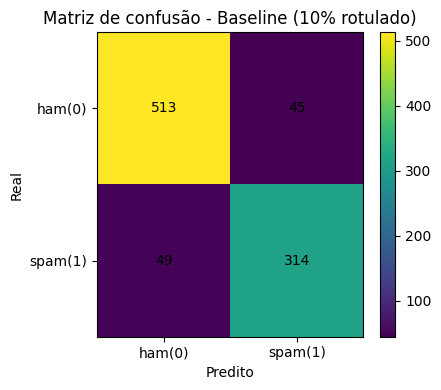

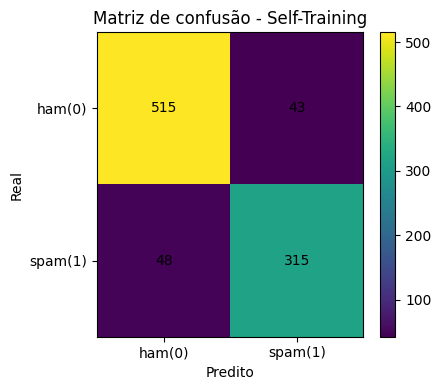

In [10]:
# Visualizei as matrizes de confusão para eu comentar os erros mais comuns

def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm, aspect="auto")

    ax.set_title(title)
    ax.set_xlabel("Predito")
    ax.set_ylabel("Real")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["ham(0)", "spam(1)"])
    ax.set_yticklabels(["ham(0)", "spam(1)"])

    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha="center", va="center")

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

plot_cm(res_baseline["cm"], "Matriz de confusão - Baseline (10% rotulado)")
plot_cm(res_self["cm"], "Matriz de confusão - Self-Training")